In [1]:
import sys
sys.path.append('../../TF-coursera/')

from vlimit import *
vram_limit()

2023-01-01 13:11:30.019777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 13:11:30.035583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 13:11:30.036453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
import os
import zipfile
import random
import shutil
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [3]:
TRAINING_DIR = 'rps-train/rps'
TESTING_DIR = 'rps-test/rps-test-set'

In [4]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  train_datagen = ImageDataGenerator(
                                  rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

  # Pass in the appropiate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=128,
                                                      color_mode='rgb',
                                                      class_mode='categorical',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1/255.0)

  # Pass in the appropiate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=128,
                                                                color_mode='rgb',
                                                                class_mode='categorical',
                                                                target_size=(150, 150))
  ### END CODE HERE
  return train_generator, validation_generator


In [5]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


### Add per-trained model

In [6]:
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [22]:
## Loading VGG16 model
pre_trained_model = VGG16(weights="imagenet",
                           include_top=False, 
                           input_shape=(150, 150, 3)
                              )
for layer in pre_trained_model.layers:
    layer.trainable = False


In [8]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 14,714,688 total parameters in this model.
There are 0 trainable parameters in this model.


In [18]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [24]:
# GRADED FUNCTION: output_of_last_layer
def output_of_last_layer(pre_trained_model):
    """
    Gets the last layer output of a model

    Args:
    pre_trained_model (tf.keras Model): model to get the last layer output from

    Returns:
    last_output: output of the model's last layer 
    """
    ### START CODE HERE
    last_desired_layer = pre_trained_model.get_layer('block4_pool')
    print('last layer output shape: ', last_desired_layer.output_shape)
    last_output = last_desired_layer.output
    print('last layer output: ', last_output)
    ### END CODE HERE

    return last_output


In [25]:
last_output = output_of_last_layer(pre_trained_model)
last_output

last layer output shape:  (None, 9, 9, 512)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 9, 9, 512), dtype=tf.float32, name=None), name='block4_pool/MaxPool:0', description="created by layer 'block4_pool'")


<KerasTensor: shape=(None, 9, 9, 512) dtype=float32 (created by layer 'block4_pool')>

In [26]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [29]:
# GRADED FUNCTION: create_final_model
def create_final_model(pre_trained_model, last_output):
    """
    Appends a custom model to a pre-trained model

    Args:
    pre_trained_model (tf.keras Model): model that will accept the train/test inputs
    last_output (tensor): last layer output of the pre-trained model

    Returns:
    model: the combined model
    """
    # Flatten the output layer to 1 dimension
    x = layers.Flatten()(last_output)
    
#     Add a fully connected layer with 1024 hidden units and ReLU activation
    x = layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.2
    x = layers.Dropout(0.2)(x)
    
    x = layers.Dense(3, activation='softmax')(x)

    # Create the complete model by using the Model class
    model = Model(inputs=pre_trained_model.input, outputs=x)

    # Compile the model
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    ### END CODE HERE

    return model


In [30]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 50,106,691 total parameters in this model.
There are 42,471,427 trainable parameters in this model.


In [26]:
# # GRADED FUNCTION: create_model
# def create_model():
#   # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
#   # USE AT LEAST 3 CONVOLUTION LAYERS

#   ### START CODE HERE

#     model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(3, activation='softmax')
#     ])



#     model.compile(optimizer='adam',
#                 loss='categorical_crossentropy',
#                 metrics=['accuracy'])
#   ### END CODE HERE

#     return model


In [34]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [35]:
# Get the untrained model
model = create_final_model(pre_trained_model, last_output)

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
 5/20 [======>.......................] - ETA: 7s - loss: 101.5171 - accuracy: 0.3625

2023-01-01 13:22:27.939716: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.79GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-01-01 13:22:27.939751: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.79GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-01-01 13:22:28.066121: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


20/20 [==============================] - 15s 744ms/step - loss: 34.1702 - accuracy: 0.4476 - val_loss: 2.1000 - val_accuracy: 0.6532
Epoch 2/15
20/20 [==============================] - 10s 494ms/step - loss: 0.9129 - accuracy: 0.7575 - val_loss: 0.2680 - val_accuracy: 0.8360
Epoch 3/15
20/20 [==============================] - 10s 493ms/step - loss: 0.2852 - accuracy: 0.9071 - val_loss: 0.1559 - val_accuracy: 0.9382
Epoch 4/15
20/20 [==============================] - 10s 494ms/step - loss: 0.1530 - accuracy: 0.9504 - val_loss: 0.1330 - val_accuracy: 0.9301
Epoch 5/15
20/20 [==============================] - 10s 494ms/step - loss: 0.1259 - accuracy: 0.9579 - val_loss: 0.1880 - val_accuracy: 0.9005
Epoch 6/15
20/20 [==============================] - 10s 493ms/step - loss: 0.0775 - accuracy: 0.9762 - val_loss: 0.1781 - val_accuracy: 0.9059
Epoch 7/15
20/20 [==============================] - 10s 495ms/step - loss: 0.0745 - accuracy: 0.9742 - val_loss: 0.2148 - val_accuracy: 0.8629
Epoch 8/1

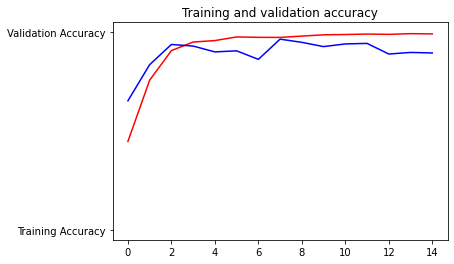

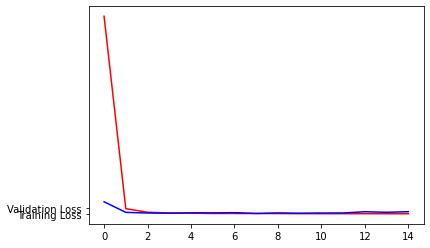

In [36]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()